In [1]:
import os
import io
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset, DatasetDict
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score
import torch
import warnings

ImageFile.LOAD_TRUNCATED_IMAGES = True
warnings.filterwarnings("ignore", category=UserWarning, message="Palette images with Transparency")

2025-06-07 00:10:50.345126: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749255050.557898      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749255050.622501      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#Loading dataset
data_train = load_dataset("imagefolder", data_dir="/kaggle/input/ai-and-real-images/train")
data_test = load_dataset("imagefolder", data_dir="/kaggle/input/ai-and-real-images/test")
data_val = load_dataset("imagefolder", data_dir="/kaggle/input/ai-and-real-images/val")

Resolving data files:   0%|          | 0/14000 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/4000 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/2000 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [3]:
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login
import wandb

user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("hugging_face")
secret_value_1 = user_secrets.get_secret("wandb.login")

login()
wandb.login(key=secret_value_1)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: songthien24 (songthien24-student) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
#Defining Label Mappings
labels = data_test["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(id2label[0],id2label[1])

fake real


In [5]:
#Loading MobileViT Feature Extractor for preprocessing images.
from transformers import MobileViTFeatureExtractor
model_name = "apple/mobilevit-small"
feature_extractor = MobileViTFeatureExtractor.from_pretrained(model_name)
feature_extractor

preprocessor_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/mobilevit/feature_extraction_mobilevit.py:28: FutureWarning: The class MobileViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use MobileViTImageProcessor instead.
  warnings.warn(


MobileViTFeatureExtractor {
  "crop_size": {
    "height": 256,
    "width": 256
  },
  "do_center_crop": true,
  "do_flip_channel_order": true,
  "do_flip_channels": true,
  "do_rescale": true,
  "do_resize": true,
  "image_processor_type": "MobileViTFeatureExtractor",
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 288
  }
}

In [6]:
#Defining Image Preprocessing Transformations
from torchvision.transforms import (
    CenterCrop,
    Compose,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
    Normalize
)

mean = [0.4502, 0.4242, 0.3926]
std = [0.2224, 0.2084, 0.2035]

if "height" in feature_extractor.size:
    size = (feature_extractor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in feature_extractor.size:
    size = feature_extractor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = feature_extractor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            Normalize(mean=mean, std=std)
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            Normalize(mean=mean, std=std)
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [7]:
train_ds = data_train['train']
val_ds = data_val['train']
test_ds = data_test['train']
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)
test_ds.set_transform(preprocess_val)

In [8]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x1024>,
 'label': 0,
 'pixel_values': tensor([[[-1.0897, -0.8252, -0.4726,  ..., -1.4777, -1.5129, -1.5306],
          [-1.1250, -0.7900, -0.3139,  ..., -1.6011, -1.4953, -1.5129],
          [-0.8605, -0.3139, -0.2963,  ..., -1.8303, -1.5129, -1.5129],
          ...,
          [-2.0243, -2.0066, -1.9361,  ..., -2.0243, -2.0066, -1.9537],
          [-2.0066, -2.0066, -1.9714,  ..., -2.0243, -2.0066, -1.9890],
          [-1.9537, -1.9714, -2.0066,  ..., -1.9537, -1.9714, -2.0066]],
 
         [[-1.3204, -1.0570, -0.7371,  ..., -1.1511, -1.1135, -1.1135],
          [-1.3957, -1.0194, -0.5489,  ..., -1.3204, -1.1323, -1.1135],
          [-1.1323, -0.5301, -0.5113,  ..., -1.6403, -1.1887, -1.1323],
          ...,
          [-2.0355, -2.0167, -1.9414,  ..., -2.0355, -2.0167, -1.9602],
          [-2.0167, -2.0167, -1.9791,  ..., -2.0355, -2.0167, -1.9979],
          [-1.9602, -1.9791, -2.0167,  ..., -1.9602, -1.9791, -2.0167

In [9]:
#Defining a Collate Function to batch data for the Trainer.
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [10]:
!pip install --quiet evaluate
import evaluate

accuracy = evaluate.load('accuracy')
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits,axis=1)
    score = accuracy.compute(predictions=predictions, references=labels)
    return score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but yo

In [11]:
#Loads and configures the MobileViT model for binary classification (fake vs. real).
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model_checkpoint = "apple/mobilevit-small"
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    num_labels =2,
    ignore_mismatched_sizes = True,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([2, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MobileViTForImageClassification(
  (mobilevit): MobileViTModel(
    (conv_stem): MobileViTConvLayer(
      (convolution): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (normalization): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLU()
    )
    (encoder): MobileViTEncoder(
      (layer): ModuleList(
        (0): MobileViTMobileNetLayer(
          (layer): ModuleList(
            (0): MobileViTInvertedResidual(
              (expand_1x1): MobileViTConvLayer(
                (convolution): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (activation): SiLU()
              )
              (conv_3x3): MobileViTConvLayer(
                (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
                (no

In [12]:
training_args = TrainingArguments(
    output_dir="./mobilevit_ai_real_classifier",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    learning_rate=3e-4,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=100,
    remove_unused_columns=False,
    report_to='tensorboard'
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=val_ds,
)

In [13]:
from PIL import ImageFile
import warnings

# Allow loading truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True
warnings.filterwarnings("ignore", category=UserWarning, message="Palette images with Transparency")

In [14]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.264000,0.248066,0.906000
2,0.209300,0.206331,0.916000
3,0.185500,0.252299,0.898500
4,0.149700,0.189353,0.923000
5,0.124600,0.209494,0.937500
6,0.117600,0.173679,0.942500
7,0.097100,0.167007,0.944000
8,0.076000,0.183119,0.943500
9,0.079600,0.160976,0.951000
10,0.068700,0.166874,0.950000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

TrainOutput(global_step=2190, training_loss=0.1436912345015295, metrics={'train_runtime': 13359.8215, 'train_samples_per_second': 10.479, 'train_steps_per_second': 0.164, 'total_flos': 1.03232627269632e+18, 'train_loss': 0.1436912345015295, 'epoch': 10.0})

In [15]:
test_results = trainer.evaluate(test_ds)
print("Test set results:", test_results)

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test set results: {'eval_loss': 0.13909530639648438, 'eval_accuracy': 0.9545, 'eval_runtime': 375.6925, 'eval_samples_per_second': 10.647, 'eval_steps_per_second': 0.168, 'epoch': 10.0}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.97      0.94      0.95      2000
        real       0.94      0.97      0.96      2000

    accuracy                           0.95      4000
   macro avg       0.96      0.95      0.95      4000
weighted avg       0.96      0.95      0.95      4000



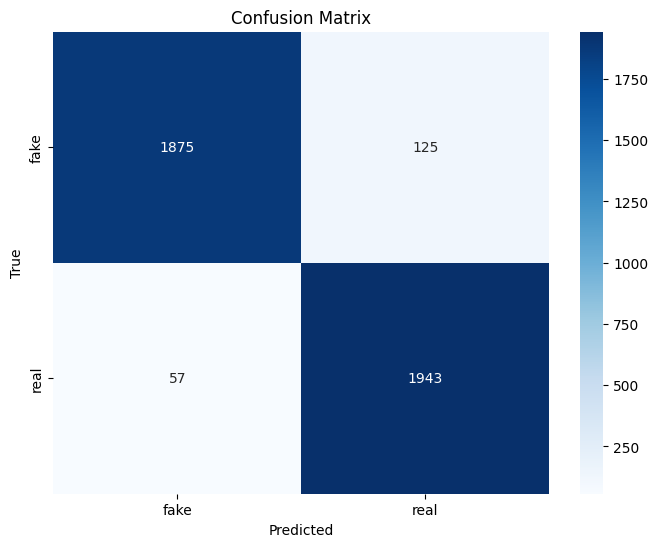

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

predictions = trainer.predict(test_ds).predictions
predicted_labels = np.argmax(predictions, axis=1)
true_labels = [sample['label'] for sample in test_ds]

print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['fake', 'real']))

cm = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['fake', 'real'], yticklabels=['fake', 'real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [17]:
model.save_pretrained("./mobilevit_ai_real_classifier0")
feature_extractor.save_pretrained("./mobilevit_ai_real_classifier1")

['./mobilevit_ai_real_classifier1/preprocessor_config.json']

In [18]:
trainer.save_model()
trainer.push_to_hub("songthienll/ai_image_generator_detect")

HfHubHTTPError: 401 Client Error: Unauthorized for url: https://huggingface.co/api/repos/create (Request ID: Root=1-6843bbe0-113d228165593c592707909d;6c339ebd-7716-430c-b5dc-44adc8796341)

Invalid username or password.

In [ ]:
from PIL import Image
import requests

url = 'https://cdn-b0.goenhance.ai/static/site/088b8580-efeb-4c05-89e9-a812af2c7459.webp'
image = Image.open(requests.get(url, stream=True).raw)
resized_image = image.resize((780,600))

resized_image

In [ ]:
#Using the Trained Model for Inference
from transformers import pipeline

pipe = pipeline("image-classification", model="songthienll/mobilevit_ai_real_classifier")
pipe(image)

In [ ]:
#Zipping and Downloading Output
!zip -r output.zip /kaggle/working/
from IPython.display import FileLink
FileLink('output.zip')